# Сборка датасета

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

RAND = 42

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/ecg_project/'

df = pd.read_csv(path + 'ecg_df.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df.head()

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,three_kurtosis,aVR_kurtosis,aVL_kurtosis,aVF_kurtosis,V1_kurtosis,V2_kurtosis,V3_kurtosis,V4_kurtosis,V5_kurtosis,V6_kurtosis
0,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
1,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
2,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
3,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,0.236699,2.782589,1.770129,0.392972,8.797798,14.848717,12.909421,8.873570,7.821621,3.677336
4,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,0.236699,2.782589,1.770129,0.392972,8.797798,14.848717,12.909421,8.873570,7.821621,3.677336


In [ ]:
df.columns.tolist()

['id',
 'one',
 'two',
 'three',
 'aVR',
 'aVL',
 'aVF',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'gender',
 'age',
 'labels',
 'signal',
 'disease_name',
 'short_disease_name',
 'one_spectral_entropy',
 'two_spectral_entropy',
 'three_spectral_entropy',
 'aVR_spectral_entropy',
 'aVL_spectral_entropy',
 'aVF_spectral_entropy',
 'V1_spectral_entropy',
 'V2_spectral_entropy',
 'V3_spectral_entropy',
 'V4_spectral_entropy',
 'V5_spectral_entropy',
 'V6_spectral_entropy',
 'one_spectral_variation',
 'two_spectral_variation',
 'three_spectral_variation',
 'aVR_spectral_variation',
 'aVL_spectral_variation',
 'aVF_spectral_variation',
 'V1_spectral_variation',
 'V2_spectral_variation',
 'V3_spectral_variation',
 'V4_spectral_variation',
 'V5_spectral_variation',
 'V6_spectral_variation',
 'one_mfcc',
 'two_mfcc',
 'three_mfcc',
 'aVR_mfcc',
 'aVL_mfcc',
 'aVF_mfcc',
 'V1_mfcc',
 'V2_mfcc',
 'V3_mfcc',
 'V4_mfcc',
 'V5_mfcc',
 'V6_mfcc',
 'one_spectral_decrease',
 'two_spectral_decrease',


In [ ]:
df.labels.nunique()

67

In [ ]:
df_raw = df.copy()

In [ ]:
df_raw.shape

(23487, 139)

In [ ]:
df_raw.drop_duplicates(subset=['id', 'short_disease_name'], keep='first').shape

(23478, 139)

In [ ]:
df_raw[df_raw.duplicated(subset=['id', 'short_disease_name'], keep=False)][['id', 'labels']]

,id,labels
17092,E02290,427084000
17093,E02290,425623009
17094,E02290,164909002
17169,E02290,427084000
17170,E02290,425623009
17171,E02290,164909002
17174,E02288,428750005
19063,E02286,426783006
19117,E02289,164909002
19171,E02288,428750005


In [ ]:
df_raw[df_raw['id'] == 'E02290'][['id', 'labels']].sort_values(by='labels')

,id,labels
17094,E02290,164909002
17171,E02290,164909002
17093,E02290,425623009
17170,E02290,425623009
17092,E02290,427084000
17169,E02290,427084000


In [ ]:
df_raw[df_raw['id'] == 'E02287'][['id', 'labels']].sort_values(by='labels')

,id,labels
19189,E02287,164934002
19220,E02287,164934002
19190,E02287,251146004
19221,E02287,251146004
19188,E02287,427084000
19219,E02287,427084000


In [ ]:
def pivot_disease_table(df: pd.DataFrame, id_col: str, disease_col: str):
    """
    Универсальная функция схлопывания датасета по id.

    Аргументы:
    - df: DataFrame с данными
    - id_col: Название колонки с идентификатором пациента
    - disease_col: Название колонки с заболеваниями

    Возвращает:
    - DataFrame, где каждая строка — один пациент, а болезни в виде списка one-hot encoding.
    - Список уникальных заболеваний в том порядке, в котором они соответствуют кодировке.
    """
    # Получаем список всех уникальных заболеваний в отсортированном порядке
    unique_diseases = sorted(df[disease_col].unique())

    # One-hot encoding для болезней
    df_one_hot = pd.crosstab(df[id_col], df[disease_col]).reset_index()

    # Определяем остальные колонки (кроме id и disease)
    other_cols = [col for col in df.columns if col not in {id_col, disease_col}]

    # Присоединяем остальные колонки (берём первое вхождение для каждого id)
    df_meta = df.groupby(id_col)[other_cols].first().reset_index()

    # Объединяем one-hot encoding с дополнительными колонками
    df_final = df_meta.merge(df_one_hot, on=id_col)

    # Преобразуем one-hot encoding в список
    df_final[disease_col] = df_final[unique_diseases].values.tolist()

    # Удаляем отдельные колонки заболеваний
    df_final = df_final.drop(columns=unique_diseases)

    return df_final, unique_diseases  # Возвращаем также список болезней

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(23468, 139)

In [ ]:
df = df.drop_duplicates(subset=['id', 'labels'], keep='first')

In [ ]:
df.shape

(23459, 139)

In [ ]:
df[df['id'] == 'E02287'][['id', 'labels']].sort_values(by='labels')

,id,labels
19189,E02287,164934002
19190,E02287,251146004
19188,E02287,427084000


In [ ]:
df = df.drop(columns=['labels', 'short_disease_name'])

In [ ]:
df.disease_name.value_counts()

,count
disease_name,
t wave abnormal,2304
nonspecific st t abnormality,1883
sinus rhythm,1750
sinus bradycardia,1675
prolonged qt interval,1391
...,...
atrial fibrillation and flutter,2
supraventricular premature beats,1
acute myocardial ischemia,1


In [ ]:
df.disease_name.value_counts()[:50]

,count
disease_name,
t wave abnormal,2304
nonspecific st t abnormality,1883
sinus rhythm,1750
sinus bradycardia,1675
prolonged qt interval,1391
sinus tachycardia,1260
left ventricular hypertrophy,1231
st interval abnormal,992
left axis deviation,940


In [ ]:
df.disease_name.value_counts()[50:]

,count
disease_name,
complete heart block,8
wandering atrial pacemaker,7
myocardial infarction,7
s t changes,6
bradycardia,6
junctional escape,5
junctional tachycardia,4
ventricular fibrillation,3
wolff parkinson white pattern,2


In [ ]:
top_50_diseases = df.disease_name.value_counts().index[:50]
df_filtered = df[df.disease_name.isin(top_50_diseases)]

In [ ]:
df_filtered['disease_name']


,disease_name
0,t wave abnormal
1,left atrial enlargement
2,prolonged qt interval
3,av block
4,atrial flutter
...,...
23482,premature atrial contraction
23483,left ventricular hypertrophy
23484,sinus rhythm
23485,nonspecific intraventricular conduction disorder


In [ ]:
# Вызываем функцию
df_transformed, disease_list = pivot_disease_table(df_filtered, id_col="id", disease_col="disease_name")

In [ ]:
df_transformed.head(50)

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,aVR_kurtosis,aVL_kurtosis,aVF_kurtosis,V1_kurtosis,V2_kurtosis,V3_kurtosis,V4_kurtosis,V5_kurtosis,V6_kurtosis,disease_name
0,E00001,136,87,-48,-112,92,19,-39,58,87,...,18.889412,22.581295,7.270635,27.737573,8.864612,11.224089,14.399584,22.400599,25.833202,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,E00002,-29,-48,-19,39,-4,-34,9,0,-19,...,18.700376,22.227619,8.279588,27.760585,9.870266,10.459103,14.405418,23.353991,24.496420,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,E00003,24,19,-4,-21,14,7,-24,-19,-34,...,15.841014,10.381798,10.971297,24.706873,3.172721,1.463750,21.683909,23.608061,11.152247,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,E00004,19,-29,-48,4,34,-39,9,19,39,...,3.783909,7.062387,1.571121,2.125262,8.923337,16.238660,21.401044,21.116673,15.166522,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,E00005,-39,-97,-58,68,9,-78,0,-82,-73,...,1.091926,5.447872,0.311795,3.908673,9.353396,4.713335,3.238531,2.028570,2.082271,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,E00006,-19,-19,0,19,-9,-9,14,-24,-43,...,23.177349,624.038663,343.776565,19.493232,33.255766,207.199358,143.611195,42.949098,23.150398,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,E00007,-48,-29,19,39,-34,-4,39,39,-19,...,20.098062,23.787178,15.574385,20.827321,18.470819,20.056618,8.144287,23.298834,20.252758,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
7,E00008,117,-292,-409,87,263,-351,136,39,-87,...,3.724076,13.757864,5.509798,0.985232,13.129081,13.423707,7.666170,8.209783,1.641280,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
8,E00009,-58,-48,9,53,-34,-19,-19,-58,-82,...,7.596162,15.967702,16.500476,2.354532,9.310852,12.937555,8.181713,9.750722,10.475673,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,E00010,58,48,-9,-53,34,19,-78,29,9,...,8.035074,18.829026,7.140248,1.778802,8.490984,18.208847,14.364962,17.307506,18.874021,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [ ]:
len(df_transformed.disease_name.iloc[0])

50

In [ ]:
disease_list

['1st degree av block',
 '2nd degree av block',
 'accelerated junctional rhythm',
 'anterior ischemia',
 'atrial fibrillation',
 'atrial flutter',
 'atrial hypertrophy',
 'atrial pacing pattern',
 'atrial tachycardia',
 'av block',
 'bundle branch block',
 'complete right bundle branch block',
 'early repolarization',
 'incomplete left bundle branch block',
 'incomplete right bundle branch block',
 'inferior ischaemia',
 'lateral ischaemia',
 'left anterior fascicular block',
 'left atrial abnormality',
 'left atrial enlargement',
 'left axis deviation',
 'left bundle branch block',
 'left posterior fascicular block',
 'left ventricular hypertrophy',
 'low qrs voltages',
 'nonspecific intraventricular conduction disorder',
 'nonspecific st t abnormality',
 'premature atrial contraction',
 'prolonged qt interval',
 'qwave abnormal',
 'r wave abnormal',
 'right atrial abnormality',
 'right axis deviation',
 'right bundle branch block',
 'right ventricular hypertrophy',
 'sinus arrhythmia

In [ ]:
len(disease_list)

50

In [ ]:
# разобьем колонки с mfcc на одна колонка - одно число для удобства работы с метрикой

def split_mfcc_columns(df):

    mfcc_columns = [col for col in df.columns if 'mfcc' in col]

    for col in mfcc_columns:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.strip('()').apply(lambda x: [float(i) for i in x.split(', ')])

        for i in range(len(df[col][0])):
            new_col_name = f"{col}_{i}"
            df[new_col_name] = df[col].apply(lambda x: x[i] if len(x) > i else None)

        df.drop(columns=[col], inplace=True)

    return df

In [ ]:
df_end = split_mfcc_columns(df_transformed)

In [ ]:
df_end.head()

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,V6_mfcc_2,V6_mfcc_3,V6_mfcc_4,V6_mfcc_5,V6_mfcc_6,V6_mfcc_7,V6_mfcc_8,V6_mfcc_9,V6_mfcc_10,V6_mfcc_11
0,E00001,136,87,-48,-112,92,19,-39,58,87,...,-2.260955,-49.999283,-30.767835,-71.271242,-87.562163,-62.512533,-137.021327,-206.115548,-96.285272,-120.946123
1,E00002,-29,-48,-19,39,-4,-34,9,0,-19,...,3.591314,-16.353693,-79.051264,-29.021013,-89.113628,-223.773220,-42.099348,-140.327477,-195.142066,-163.030647
2,E00003,24,19,-4,-21,14,7,-24,-19,-34,...,27.681020,93.736727,-55.728658,-269.272164,-177.249977,-77.093579,-184.398706,-229.366721,-107.847786,-173.606079
3,E00004,19,-29,-48,4,34,-39,9,19,39,...,19.630106,19.844677,-61.307162,-105.069194,-90.358914,-54.206987,-164.607119,-257.293014,-249.690065,-112.961817
4,E00005,-39,-97,-58,68,9,-78,0,-82,-73,...,55.606757,-35.645738,-94.884154,-107.153718,-37.620155,16.582211,-145.458923,-162.417971,-167.920031,-129.957256


In [ ]:
df_end.shape

(10335, 269)

In [ ]:
# сохраним датасет в этом состоянии
df_end.to_csv('ecg_df.csv', index=False)

In [ ]:
from google.colab import files

files.download('ecg_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Обучение моделей CatBoost, LGBM

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
import time
from sklearn.model_selection import StratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
import shap

In [ ]:
df_end = df_end.drop(columns=["id", "signal"])
df_end['gender'] = df_end['gender'].map({'Male': 0, 'Female': 1})

In [ ]:
X = df_end.drop(columns=["disease_name"])
y = df_end["disease_name"]

In [ ]:
# Преобразуем y в numpy-массив, где каждая строка — бинарный вектор меток
y_array = np.array(y.tolist())
X_array = X.values

X_train_array, y_train_array, X_test_array, y_test_array = iterative_train_test_split(
    X_array, y_array, test_size=0.3
)

# При необходимости возвращаем обратно в DataFrame
X_train = pd.DataFrame(X_train_array, columns=X.columns)
X_test = pd.DataFrame(X_test_array, columns=X.columns)
y_train = pd.DataFrame(y_train_array)
y_test = pd.DataFrame(y_test_array)

In [ ]:
y_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Cтандартизация
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
import time
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
# Замер времени обучения
start_time = time.time()

# Инициализация модели CatBoost с фиксированными параметрами
model = MultiOutputClassifier(CatBoostClassifier(
    iterations=500,      # можно подобрать по усмотрению
    depth=6,             # стандартная глубина дерева
    learning_rate=0.1,   # стандартная скорость обучения
    eval_metric="TotalF1",
    verbose=2
))

# Обучение модели
model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time # 46 min

print(f"Время обучения: {training_time:.4f} сек.")

Выходные данные были обрезаны до нескольких последних строк (5000).
42:	learn: 0.9985512	total: 3.17s	remaining: 33.7s
44:	learn: 0.9988616	total: 3.32s	remaining: 33.5s
46:	learn: 0.9988616	total: 3.46s	remaining: 33.3s
48:	learn: 0.9988616	total: 3.6s	remaining: 33.1s
50:	learn: 0.9988616	total: 3.77s	remaining: 33.2s
52:	learn: 0.9988616	total: 4s	remaining: 33.8s
54:	learn: 0.9991184	total: 4.29s	remaining: 34.7s
56:	learn: 0.9991184	total: 4.56s	remaining: 35.4s
58:	learn: 0.9993376	total: 4.83s	remaining: 36.1s
60:	learn: 0.9993376	total: 5.09s	remaining: 36.6s
62:	learn: 0.9993376	total: 5.36s	remaining: 37.2s
64:	learn: 0.9993376	total: 5.64s	remaining: 37.7s
66:	learn: 0.9993376	total: 5.9s	remaining: 38.2s
68:	learn: 0.9993376	total: 6.17s	remaining: 38.5s
70:	learn: 0.9993376	total: 6.43s	remaining: 38.9s
72:	learn: 0.9993376	total: 6.7s	remaining: 39.2s
74:	learn: 0.9993376	total: 6.96s	remaining: 39.4s
76:	learn: 0.9995296	total: 7.21s	remaining: 39.6s
78:	learn: 0.9995296

In [ ]:
# Получаем предсказания для каждого таргета отдельно
preds = []
for clf in model.estimators_:
    p = clf.predict(X_test)
    # Если предсказания имеют форму (n_samples, 1), приводим к (n_samples,)
    if p.ndim > 1 and p.shape[1] == 1:
        p = p.ravel()
    preds.append(p)

# Объединяем предсказания в один массив
y_pred = np.column_stack(preds)

In [ ]:
f1_scores_cb = []
precision_scores_cb = []
recall_scores_cb = []
n_targets = y_test.shape[1]

for i in range(n_targets):
    score = f1_score(y_test.iloc[:, i], y_pred[:, i], average="weighted")
    f1_scores_cb.append(score)

    precision = precision_score(y_test.iloc[:, i], y_pred[:, i], average="weighted")
    precision_scores_cb.append(precision)

    recall = recall_score(y_test.iloc[:, i], y_pred[:, i], average="weighted")
    recall_scores_cb.append(recall)

overall_precision_cb = np.mean(precision_scores_cb)
overall_recall_cb = np.mean(recall_scores_cb)
overall_f1_cb = np.mean(f1_scores_cb)

print("Overall Precision score:", overall_precision_cb)
print("Overall Recall score:", overall_recall_cb)
print("Overall F1 score:", overall_f1_cb)

Overall Precision score: 0.9451339163937589
Overall Recall score: 0.9585885399805761
Overall F1 score: 0.9447062057124941


In [ ]:
f1_scores_cb = []
precision_scores_cb = []
recall_scores_cb = []
n_targets = y_test.shape[1]

for i in range(n_targets):
    score = f1_score(y_test.iloc[:, i], y_pred[:, i], average="macro")
    f1_scores_cb.append(score)

    precision = precision_score(y_test.iloc[:, i], y_pred[:, i], average="macro")
    precision_scores_cb.append(precision)

    recall = recall_score(y_test.iloc[:, i], y_pred[:, i], average="macro")
    recall_scores_cb.append(recall)

overall_precision_cb = np.mean(precision_scores_cb)
overall_recall_cb = np.mean(recall_scores_cb)
overall_f1_cb = np.mean(f1_scores_cb)

print("Overall Precision score:", overall_precision_cb)
print("Overall Recall score:", overall_recall_cb)
print("Overall F1 score:", overall_f1_cb)

Overall Precision score: 0.6706065000611658
Overall Recall score: 0.5439726081768819
Overall F1 score: 0.5488320827174111


In [ ]:
f1_scores_cb = []
precision_scores_cb = []
recall_scores_cb = []
n_targets = y_test.shape[1]

for i in range(n_targets):
    score = f1_score(y_test.iloc[:, i], y_pred[:, i], average="micro")
    f1_scores_cb.append(score)

    precision = precision_score(y_test.iloc[:, i], y_pred[:, i], average="micro")
    precision_scores_cb.append(precision)

    recall = recall_score(y_test.iloc[:, i], y_pred[:, i], average="micro")
    recall_scores_cb.append(recall)

overall_precision_cb = np.mean(precision_scores_cb)
overall_recall_cb = np.mean(recall_scores_cb)
overall_f1_cb = np.mean(f1_scores_cb)

print("Overall Precision score:", overall_precision_cb)
print("Overall Recall score:", overall_recall_cb)
print("Overall F1 score:", overall_f1_cb)

Overall Precision score: 0.9585885399805761
Overall Recall score: 0.9585885399805761
Overall F1 score: 0.9585885399805761


In [ ]:
# SHAP
explainer = shap.Explainer(model.estimators_[0])  # Берем первый классификатор из MultiOutputClassifier
shap_values = explainer(X_train_scaled)

# Усредняем абсолютные значения SHAP и сортируем признаки
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# Выбираем топ-100 признаков
top_100_features = feature_importance.head(100).index.tolist()

print("Топ-100 важных признаков:")
print(top_100_features)

Топ-100 важных признаков:
['age', 'V4_mean_abs_diff', 'V1_mfcc_10', 'V4_spectral_decrease', 'V5_mean_abs_diff', 'V2_kurtosis', 'gender', 'V5_enthropy', 'one_mfcc_8', 'aVL_mfcc_8', 'three_mean_abs_diff', 'V2_mfcc_9', 'V6_mean_abs_diff', 'V2_enthropy', 'one_mfcc_9', 'two_mean_abs_diff', 'two_mfcc_5', 'V6_spectral_entropy', 'aVR_abs_energy', 'V1_abs_energy', 'V1_mfcc_11', 'V2_mfcc_11', 'V1_kurtosis', 'V5_mean_diff', 'three_abs_energy', 'V1_mfcc_9', 'V1_spectral_entropy', 'aVF_mean_abs_diff', 'V3_mfcc_9', 'one_abs_energy', 'V5_spectral_decrease', 'V1_mean_abs_diff', 'aVL_skewness', 'V5_mfcc_6', 'aVR_spectral_entropy', 'V6_abs_energy', 'V4_mfcc_0', 'two_abs_energy', 'V3_enthropy', 'one_spectral_entropy', 'V3_mfcc_10', 'aVL_enthropy', 'aVR_mfcc_5', 'aVF_mfcc_10', 'aVR_mean_abs_diff', 'one_mean_abs_diff', 'three_kurtosis', 'three_mfcc_3', 'V2_mean_diff', 'aVL_mfcc_4', 'two_spectral_entropy', 'aVF_mfcc_0', 'V5_abs_energy', 'V6_spectral_decrease', 'V6_mean_diff', 'V1_enthropy', 'V2_mfcc_5', 'V2

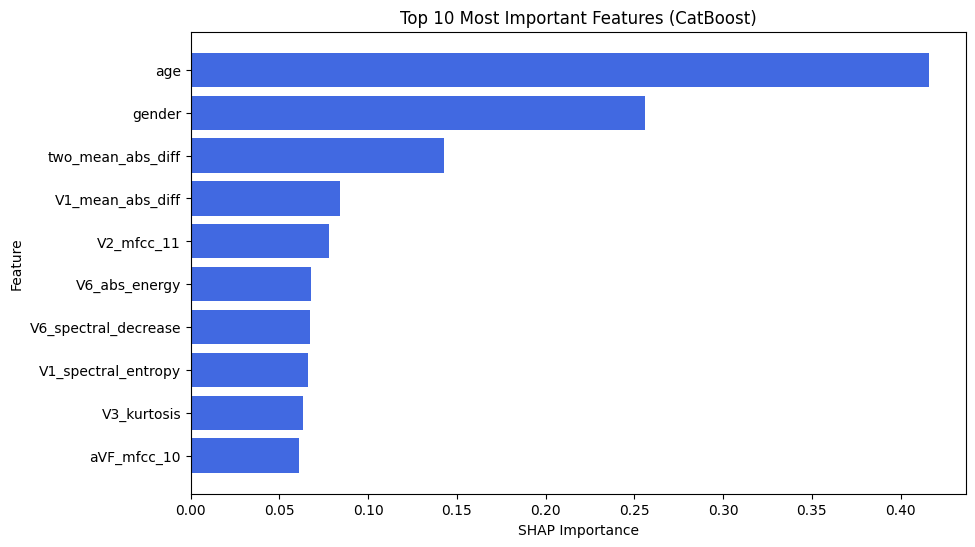

In [ ]:
# Вычисляем SHAP-значения для первого классификатора в MultiOutputClassifier
explainer = shap.TreeExplainer(model.estimators_[0])
shap_values = explainer.shap_values(X_test)

# LightGBM выдает список SHAP-значений для каждого класса, усредняем их
if isinstance(shap_values, list):
    shap_values = np.mean(np.abs(shap_values), axis=0)

# Считаем среднее абсолютное значение SHAP по каждому признаку
shap_importance = np.abs(shap_values).mean(axis=0)

# Создаем DataFrame с важностью признаков
shap_importance_df = pd.DataFrame({'feature': X_test.columns, 'importance': shap_importance})
shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False).head(10)

# Строим график
plt.figure(figsize=(10, 6))
plt.barh(shap_importance_df['feature'], shap_importance_df['importance'], color='royalblue')
plt.xlabel("SHAP Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features (CatBoost)")
plt.gca().invert_yaxis()
plt.show()

# LGBM

In [ ]:
import time
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
# # Замер времени обучения
# start_time = time.time()

# # Инициализация модели LGBM с фиксированными параметрами
# model = MultiOutputClassifier(LGBMClassifier(
#     n_estimators=500,     # аналог iterations в CatBoost
#     max_depth=6,          # стандартная глубина дерева
#     learning_rate=0.1,    # стандартная скорость обучения
#     verbose=1             # уровень логирования (можно установить в -1 для отключения)
# ))

# # Обучение модели
# model.fit(X_train, y_train)

# end_time = time.time()
# training_time = end_time - start_time
# print(f"Время обучения: {training_time:.4f} сек.")

In [ ]:
# Функция для вычисления Total F1
def total_f1_metric(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)  # Бинаризация предсказаний
    f1_scores = [f1_score(y_true[:, i], y_pred[:, i], average="weighted") for i in range(y_true.shape[1])]
    return np.mean(f1_scores)

# Кастомная функция для LightGBM
def custom_f1_metric(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)  # LightGBM дает предсказания в виде 1D массива
    return "TotalF1", total_f1_metric(y_true, y_pred), True

# Инициализация модели LGBM
model = MultiOutputClassifier(LGBMClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    verbose=1
))

# Обучение модели с кастомной метрикой
model.fit(X_train, y_train, eval_metric=custom_f1_metric)

# Вычисление времени обучения
end_time = time.time()
training_time = end_time - start_time
print(f"Время обучения: {training_time:.4f} сек.")

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1225, number of negative: 6021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67083
[LightGBM] [Info] Number of data points in the train set: 7246, number of used features: 266
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169059 -> initscore=-1.592313
[LightGBM] [Info] Start training from score -1.592313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
# Получаем предсказания для каждого таргета отдельно
preds = []
for clf in model.estimators_:
    p = clf.predict(X_test)
    # Если предсказания имеют форму (n_samples, 1), приводим к (n_samples,)
    if p.ndim > 1 and p.shape[1] == 1:
        p = p.ravel()
    preds.append(p)

# Объединяем предсказания в один массив
y_pred = np.column_stack(preds)

In [ ]:
f1_scores_lgbm = []
precision_scores_lgbm = []
recall_scores_lgbm = []
n_targets = y_test.shape[1]

for i in range(n_targets):
    score = f1_score(y_test.iloc[:, i], y_pred[:, i], average="weighted")
    f1_scores_lgbm.append(score)

    precision = precision_score(y_test.iloc[:, i], y_pred[:, i], average="weighted")
    precision_scores_lgbm.append(precision)

    recall = recall_score(y_test.iloc[:, i], y_pred[:, i], average="weighted")
    recall_scores_lgbm.append(recall)

overall_precision_lgbm = np.mean(precision_scores_lgbm)
overall_recall_lgbm = np.mean(recall_scores_lgbm)
overall_f1_lgbm = np.mean(f1_scores_lgbm)

print("Overall Precision score:", overall_precision_lgbm)
print("Overall Recall score:", overall_recall_lgbm)
print("Overall F1 score:", overall_f1_lgbm)

Overall Precision score: 0.949721395130856
Overall Recall score: 0.9588022013596632
Overall F1 score: 0.9448197489970073


In [ ]:
f1_scores_lgbm = []
precision_scores_lgbm = []
recall_scores_lgbm = []
n_targets = y_test.shape[1]

for i in range(n_targets):
    score = f1_score(y_test.iloc[:, i], y_pred[:, i], average="macro")
    f1_scores_lgbm.append(score)

    precision = precision_score(y_test.iloc[:, i], y_pred[:, i], average="macro")
    precision_scores_lgbm.append(precision)

    recall = recall_score(y_test.iloc[:, i], y_pred[:, i], average="macro")
    recall_scores_lgbm.append(recall)

overall_precision_lgbm = np.mean(precision_scores_lgbm)
overall_recall_lgbm = np.mean(recall_scores_lgbm)
overall_f1_lgbm = np.mean(f1_scores_lgbm)

print("Overall Precision score:", overall_precision_lgbm)
print("Overall Recall score:", overall_recall_lgbm)
print("Overall F1 score:", overall_f1_lgbm)

Overall Precision score: 0.7016032024188681
Overall Recall score: 0.5488957827901194
Overall F1 score: 0.5548781780056445


In [ ]:
f1_scores_lgbm = []
precision_scores_lgbm = []
recall_scores_lgbm = []
n_targets = y_test.shape[1]

for i in range(n_targets):
    score = f1_score(y_test.iloc[:, i], y_pred[:, i], average="micro")
    f1_scores_lgbm.append(score)

    precision = precision_score(y_test.iloc[:, i], y_pred[:, i], average="micro")
    precision_scores_lgbm.append(precision)

    recall = recall_score(y_test.iloc[:, i], y_pred[:, i], average="micro")
    recall_scores_lgbm.append(recall)

overall_precision_lgbm = np.mean(precision_scores_lgbm)
overall_recall_lgbm = np.mean(recall_scores_lgbm)
overall_f1_lgbm = np.mean(f1_scores_lgbm)

print("Overall Precision score:", overall_precision_lgbm)
print("Overall Recall score:", overall_recall_lgbm)
print("Overall F1 score:", overall_f1_lgbm)

Overall Precision score: 0.9588022013596632
Overall Recall score: 0.9588022013596632
Overall F1 score: 0.9588022013596632


In [ ]:
# SHAP
explainer = shap.Explainer(model.estimators_[0])  # Берем первый классификатор из MultiOutputClassifier
shap_values = explainer(X_train_scaled)

# Усредняем абсолютные значения SHAP и сортируем признаки
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# Выбираем топ-100 признаков
top_100_features = feature_importance.head(100).index.tolist()

print("Топ-100 важных признаков:")
print(top_100_features)

Топ-100 важных признаков:
['V2_kurtosis', 'aVR_mean_abs_diff', 'age', 'V5_mean_abs_diff', 'V4_mean_abs_diff', 'V2_mfcc_11', 'V6_spectral_decrease', 'one_abs_energy', 'V2_mfcc_9', 'V3_spectral_entropy', 'V4_spectral_decrease', 'V6_mean_abs_diff', 'V3_kurtosis', 'two_skewness', 'one_spectral_entropy', 'aVL_mean_abs_diff', 'V1_mfcc_10', 'V1_spectral_variation', 'one_mfcc_10', 'one_mfcc_8', 'two_mfcc_11', 'one_mfcc_9', 'two_mean_abs_diff', 'gender', 'V1_abs_energy', 'aVR_spectral_entropy', 'V5_mfcc_5', 'V2_mean_abs_diff', 'aVR_enthropy', 'aVF_mfcc_10', 'V1_mean_abs_diff', 'two_mfcc_5', 'V5_spectral_decrease', 'V1_kurtosis', 'V4_enthropy', 'V4_spectral_entropy', 'V1_skewness', 'aVR_mean_diff', 'three_kurtosis', 'V5_kurtosis', 'V5_abs_energy', 'V1_mfcc_8', 'aVL_enthropy', 'V5_mean_diff', 'V2_abs_energy', 'aVF_mean_abs_diff', 'one_spectral_decrease', 'V1_spectral_entropy', 'V5_mfcc_0', 'V2_mean_diff', 'three_mfcc_3', 'V6_skewness', 'aVL_mean_diff', 'two_spectral_decrease', 'V6_mfcc_8', 'V5_mf

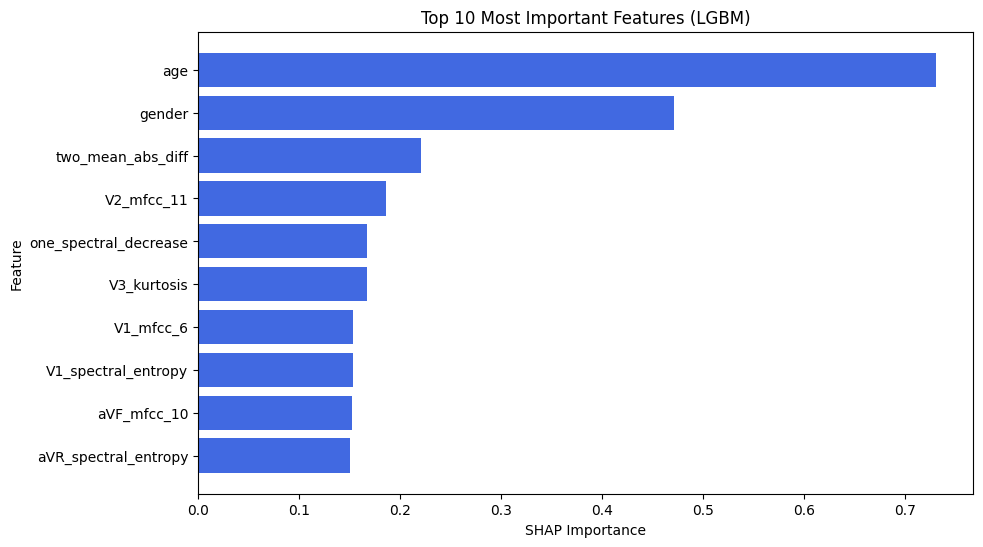

In [ ]:
# Вычисляем SHAP-значения для первого классификатора в MultiOutputClassifier
explainer = shap.TreeExplainer(model.estimators_[0])
shap_values = explainer.shap_values(X_test)

# LightGBM выдает список SHAP-значений для каждого класса, усредняем их
if isinstance(shap_values, list):
    shap_values = np.mean(np.abs(shap_values), axis=0)

# Считаем среднее абсолютное значение SHAP по каждому признаку
shap_importance = np.abs(shap_values).mean(axis=0)

# Создаем DataFrame с важностью признаков
shap_importance_df = pd.DataFrame({'feature': X_test.columns, 'importance': shap_importance})
shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False).head(10)

# Строим график
plt.figure(figsize=(10, 6))
plt.barh(shap_importance_df['feature'], shap_importance_df['importance'], color='royalblue')
plt.xlabel("SHAP Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features (LGBM)")
plt.gca().invert_yaxis()
plt.show()